# pystan for subMM SEDs

Notebook to use `pystan` to sample submm SED models.

### Issues:

* Can I use my getdist (or A Lewis') with this output?
* how do I deal with the mixture model with "duplicate" parameters?
  * currently using `positive ordered` vector of vector of temperatures
* Add optical-depth model


In [1]:
from __future__ import print_function

import os
import sys
import warnings

import pystan
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.environ['HOME']+'/home/proj/stats/MCMC')
# sys.path.append(os.environ['HOME']+'/home/proj/stats/MCMC/submmSED')

import data

%matplotlib inline

In [2]:
herus_file = "august6table.csv"
speed_of_light = 299792.458 ### micron GHz
d = data.readfluxes_DLC_2014(filename=herus_file)

In [3]:
def makeStanDict(dobj, N_comp=2):
    """ convert from an MCMC object to a dict for input to STAN"""
    return dict(
        N_comp = N_comp,
        N_band = dobj.n,
        nu_obs = dobj.freq_obs,
        flux = dobj.d,
        sigma = dobj.sig,
        z = dobj.z
    )

In [4]:
submm_data = """
    data {

        int<lower=1> N_comp; // number of greybody components (fixed model parameter)

        int<lower=1> N_band;   // number of photometric bands
        vector[N_band] nu_obs; // observed frequency
        vector[N_band] flux;   // observed flux
        vector[N_band] sigma;  // error
        real z;                // redshift
    }
    
    transformed data {
        vector[N_band] nu;     // rest frame frequency
        nu <- (1+z)*nu_obs;    // could do this outside of stan...
    }
    
"""

submm_functions = """
    functions {
        
        real greybody(real beta, real T, real nu) {
          // greybody, normalized to unit flux at nu=nu_0
            real h_over_k;
            real x;
            real nu_0;
            real x_0;
            
            nu_0 <- 1000;

            h_over_k <- 0.04799237;       //  K/Ghz
            x <- h_over_k * nu / T;
            x_0 <- h_over_k * nu_0 / T;
            return (pow(nu/nu_0, 3+beta) * expm1(x_0) / expm1(x));
        }
    }
"""

submm_model_greybody_1 = """
    // single-component greybody -- not used
    parameters {
        real amplitude<lower=0.0>;
        real T<lower=3, upper=100.0>; // Temperature in K
        real beta<lower=0, upper=3>;  // greybody factor
    }
    
    transformed parameters {
        real totalflux<lower=0>[N_band];
        for (band in 1:N_band)
            totalflux[band] <- amplitude * greybody(beta, T, nu[band])
    }
    
    model {
        // no explicit priors on parameters -- improper... 
        flux ~ normal(totalflux, sigma)
    }
    
"""

submm_model_greybody = """
    parameters {
    // nb. N_comp, N_band are data
//        vector[N_comp] log10amplitude;
        vector<lower=0>[N_comp] amplitude;
//          vector<lower=3, upper=100.0>[N_comp] T; // Temperature in K  
        positive_ordered[N_comp] T;
        vector<lower=0, upper=3>[N_comp] beta;  // greybody factor    
    }
    
// not used, since this is only needed if you want to keep track of these parameters.
//    transformed parameters {
//        real<lower=0> fluxes[N_band, N_comp];
//        real<lower=0> totalflux[N_band];
//        real<lower=0> amplitude[N_comp];
//        
//        for (comp in 1:N_comp)
//            amplitude[comp] <- pow(10.0, log10amplitude[comp]);
//        
//        for (band in 1:N_band) {
//            for (comp in 1:N_comp) {  // vectorize over this?
//                fluxes[band, comp] <- amplitude[comp] * greybody(beta[comp], T[comp], nu[band]);
//            }
//           totalflux[band] <- sum(fluxes[band]);
//        }
//    }
    
    model {
        real fluxes[N_band, N_comp];
        vector[N_band] totalflux;
//        vector[N_comp] amplitude;
        
//        for (comp in 1:N_comp)
//            amplitude[comp] <- pow(10.0, log10amplitude[comp]);
        
        for (band in 1:N_band) {
            for (comp in 1:N_comp) {  // vectorize over this?
                fluxes[band, comp] <- amplitude[comp] * greybody(beta[comp], T[comp], nu[band]);
            }
            totalflux[band] <- sum(fluxes[band]);
        }

        // no explicit priors on parameters -- improper... 
       flux ~ normal(totalflux, sigma);
    }
    
"""


submm_model_greybody_b2 = """

//// like submm_model_greybody, but with fixed beta=2 
    parameters {
    // nb. N_comp, N_band are data
        vector<lower=0>[N_comp] amplitude;
//          vector<lower=3, upper=100.0>[N_comp] T; // Temperature in K  
        positive_ordered[N_comp] T;
    }

    model {
        real fluxes[N_band, N_comp];
        vector[N_band] totalflux;

        for (band in 1:N_band) {
            for (comp in 1:N_comp) {
                fluxes[band, comp] <- amplitude[comp] * greybody(2.0, T[comp], nu[band]);
            }
            totalflux[band] <- sum(fluxes[band]);
        }

        // no explicit priors on parameters -- improper... 
       flux ~ normal(totalflux, sigma);
    }
    
"""

In [8]:
greybody_code = submm_functions + submm_data + submm_model_greybody
greybody_model = pystan.StanModel(model_code=greybody_code, model_name="greybody")
greybody_b2_code = submm_functions + submm_data + submm_model_greybody_b2
greybody_b2_model = pystan.StanModel(model_code=greybody_b2_code, model_name="greybody_beta2")

In [43]:
obj = 7
dobj = d[obj]
N_comp = 2
print(d[obj].name)

fit = greybody_model.sampling(data=makeStanDict(d[obj], N_comp=N_comp),
                  iter=10000, chains=4)


IRAS06206-6315


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing

In [45]:
print(fit.extract(permuted=True).keys())
print(fit.extract(permuted=False).shape)
print(fit.model_pars)
print(fit.extract(permuted=True)['amplitude'].shape)
print([a.shape for a in fit.extract(permuted=True)['amplitude'].T])
print(fit)

[u'amplitude', u'T', u'beta', u'lp__']
(5000, 4, 7)
[u'amplitude', u'T', u'beta']
(20000, 2)
[(20000,), (20000,)]
Inference for Stan model: greybody_62ed89537f2de8a0302771c2118de22b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
amplitude[0]    0.4  1.6e-3   0.06   0.31   0.36   0.39   0.45   0.55 1598.0    1.0
amplitude[1]   0.19  1.6e-3   0.06   0.04   0.14    0.2   0.23   0.28 1602.0    1.0
T[0]          20.31    0.03    1.6  17.58   19.2  20.12  21.31  23.89 2091.0    1.0
T[1]          54.77    0.15   7.55   41.0  49.33  54.39  59.93  69.98 2507.0    1.0
beta[0]        2.69  5.3e-3   0.22   2.24   2.52   2.73   2.88   2.99 1722.0    1.0
beta[1]        1.48    0.01   0.45   0.88   1.16   1.37    1.7   2.65 1680.0    1.0
lp__          -7.81    0.03   1.82  -12.2  -8.78  -7.49  -6.48  -5.32 2819.0    1.0

Samples were drawn using

In [ ]:
fits = {}
niter = 10000
nchains = 4
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for dobj in d:
        print(dobj.name)
        fits[dobj.name] = []
        for n_comp in (1,2):
            fit_beta = greybody_model.sampling(data=makeStanDict(dobj, N_comp=n_comp),
                                        iter=niter, chains=nchains)
            fits[dobj.name].append(fit_beta)
            try:
                print(fit_beta)
            except OverflowError:
                print("Can't print! %s %d unconstrained beta" % (dobj.name, n_comp))

            fit_b2 = greybody_b2_model.sampling(data=makeStanDict(dobj, N_comp=n_comp),
                                        iter=niter, chains=nchains)
            fits[dobj.name].append(fit_b2)
            try:
                print(fit_b2)
            except OverflowError:
                print("Can't print! %s %d beta=2"  % (dobj.name, n_comp))



IRAS00188-0856
Inference for Stan model: greybody_62ed89537f2de8a0302771c2118de22b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
amplitude[0]   0.38  5.4e-5 3.2e-3   0.38   0.38   0.38   0.39   0.39 3511.0    1.0
T[0]           35.1    0.02   1.08  32.96  34.38  35.11  35.82  37.23 3102.0    1.0
beta[0]        1.73  1.1e-3   0.06   1.62   1.69   1.73   1.77   1.85 2939.0    1.0
lp__          -10.0    0.02   1.19 -13.09 -10.54  -9.69  -9.12  -8.63 3333.0    1.0

Samples were drawn using NUTS(diag_e) at Wed Aug 19 16:04:59 2015.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: greybody_beta2_1dbccaaf2b16ec8ec87279bc6af8951f.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draw

In [8]:
import pickle
with open("greybody_model_stan.pkl", "wb") as f:
    pickle.dump(greybody_model, f)
with open("greybody_b2_model_stan.pkl", "wb") as f:
    pickle.dump(greybody_b2_model, f)
with open("greybody_fits_stan.pkl", "wb") as f:
    pickle.dump(fits, f)



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/pickle.py:306: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  rv = reduce(self.proto)


In [ ]:
import getdist
def pystan2getdist(fit):
    """ convert a pystan fit object into an A Lewis MCSamples object """
    
    ### have to either deal with combining chains (permute=False) 
    ###                       or separating vector-valued parameters (permute=True)
    
    sample_dict = fit.extract(permuted=True)
    names = []
    labels = []
    samples = []
    for par, samps in sample_dict.iteritems():
        if par == "lp__":
            loglikes = -samps
        else:
            if len(samps.shape)==1:
                names.append(par)
                labels.append(par)
                samples.append(samps)
            else:
                for i,s in enumerate(samps.T):
                    samples.append(s)
                    names.append(par+str(i+1))
                    labels.append(par+"_"+str(i+1))
    
    return getdist.MCSamples(names=labels, samples=samples, loglikes=loglikes, labels=labels)

In [ ]:
gds = {}
for obj, fs in fits.iteritems():
    gds[obj] = [pystan2getdist(f) for f in fs]
### order is 1comp, 2comp, 1compb2, 2compb2
    
with open("greybody_getdist.pkl", "wb") as fil:
    pickle.dump(gds, fil)

        
    

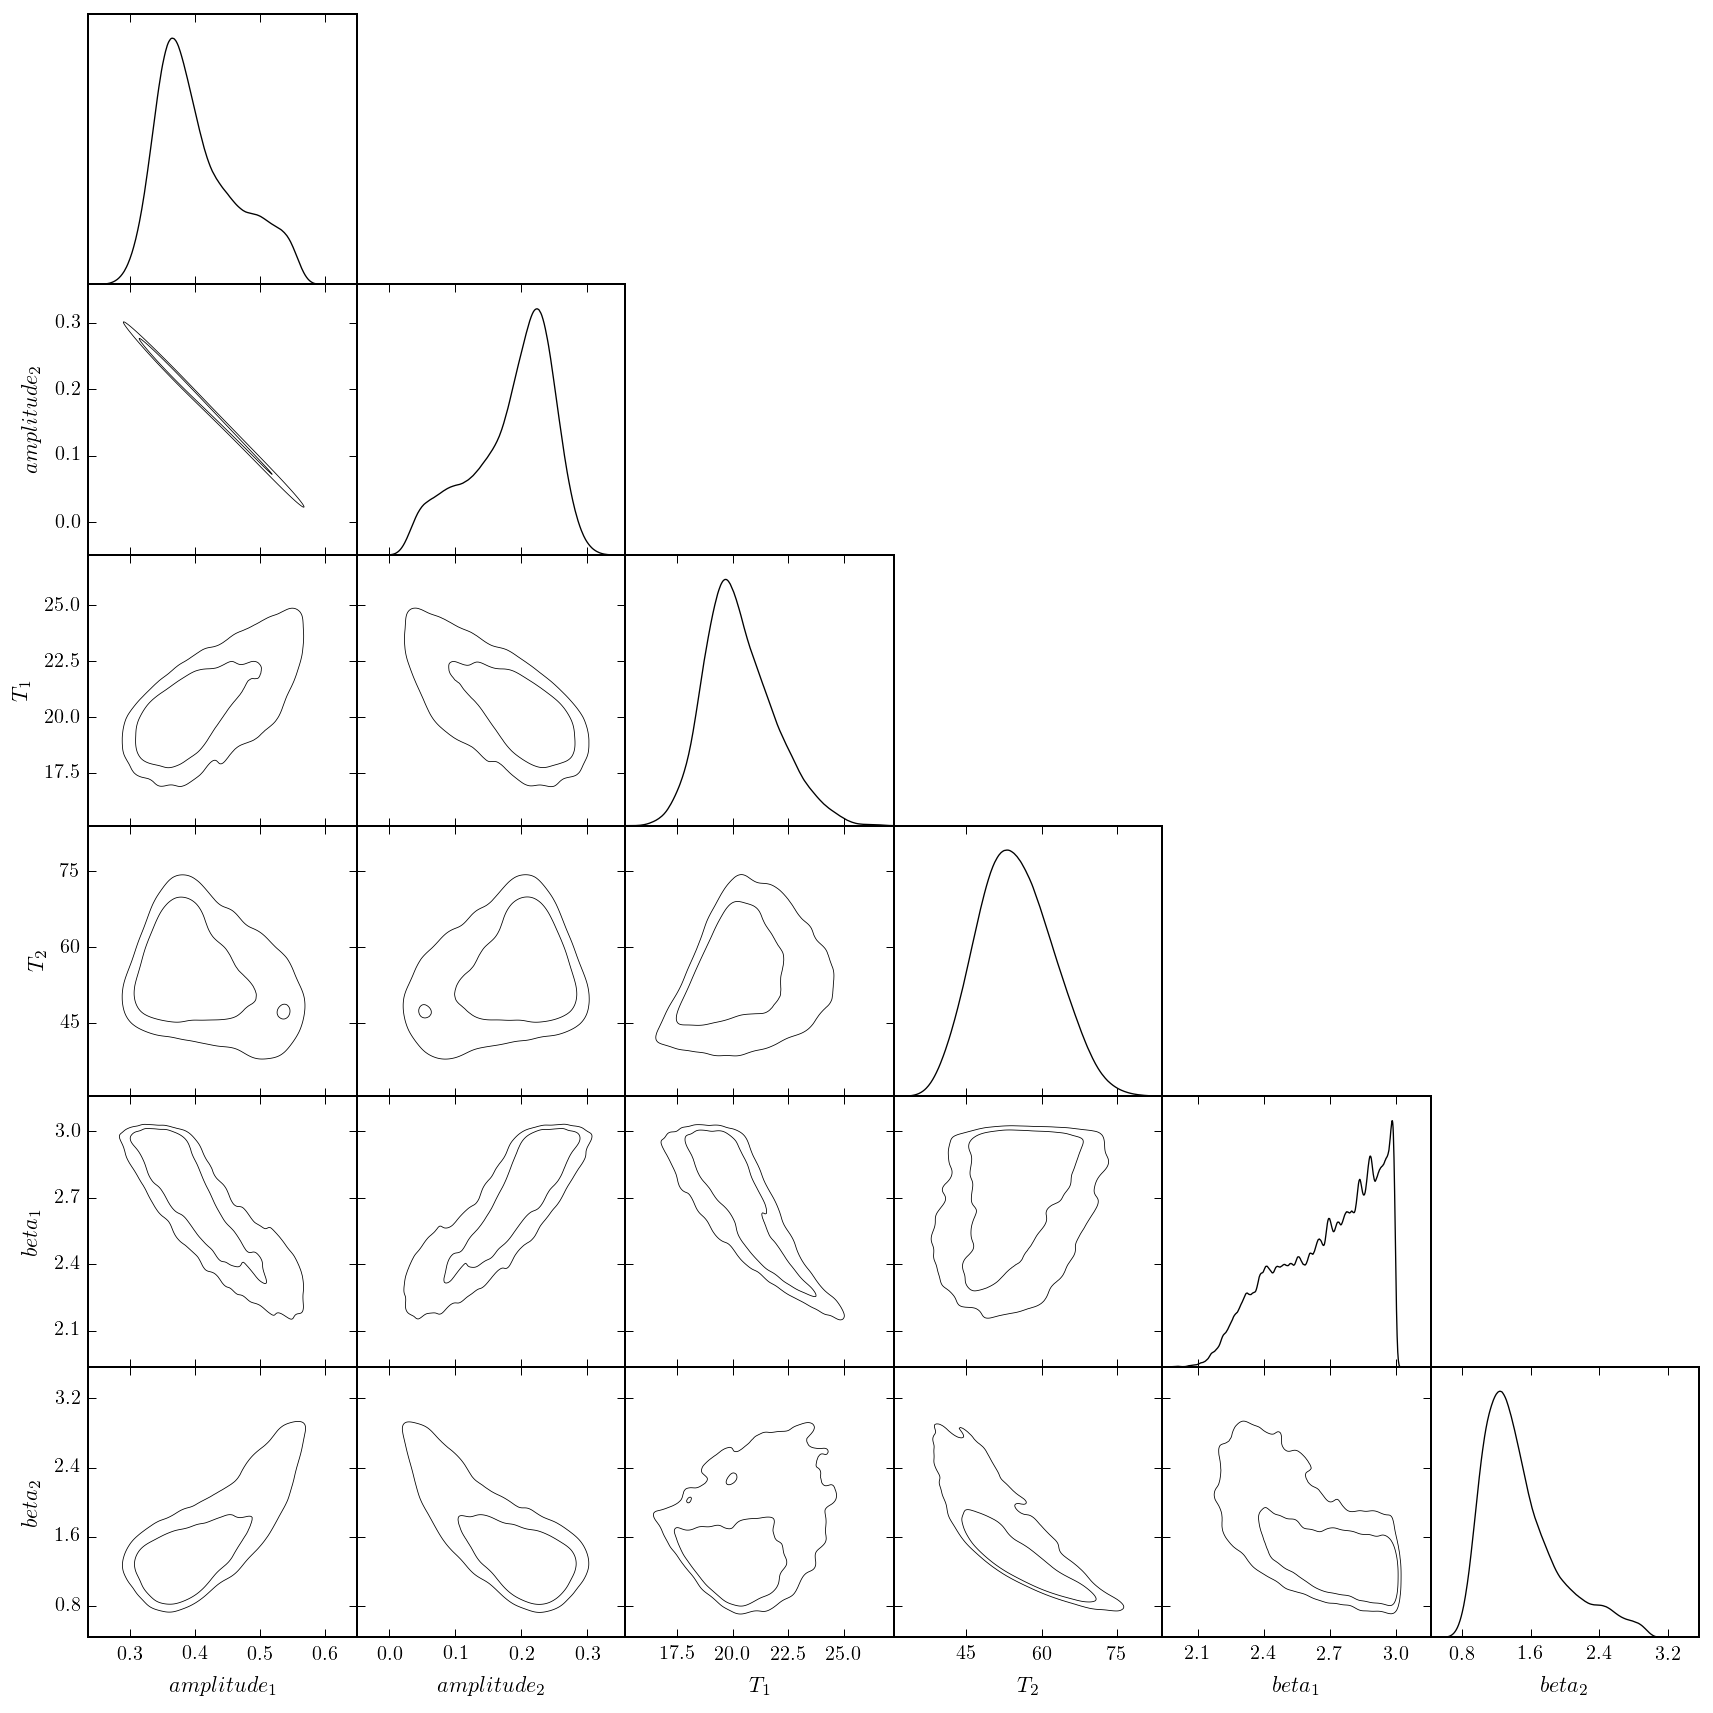

In [46]:
import getdist.plots
gd = pystan2getdist(fit)
g = getdist.plots.getSubplotPlotter()
g.triangle_plot(gd)